# Datasets (Sentiment) - Yelp - Categories

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
! pip install jsonlines

In [ ]:
! pip install syntok

[]

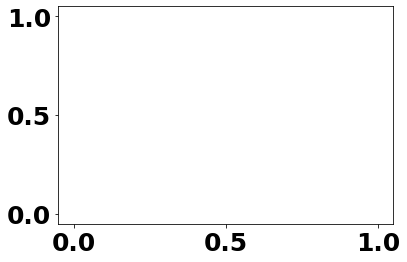

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [4]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")
data_yelp_path = Path("/disk1/users/ekoerner/same-side-classification/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [5]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [6]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [7]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [8]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list, keep businesses in list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered


def filter_by_businesses_not_same(df, lst_business_ids):
    # filter with list, keep businesses that are not in list
    df_filtered = df[~df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [9]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [10]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [11]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [12]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [13]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

##### Make category comparisons

In [14]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [15]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij_union = businesses_i | businesses_j
            businesses_ij_intersect = businesses_i & businesses_j
            num_businesses_ij = len(businesses_ij_intersect)
            #array_line.append(num_businesses_ij)
            array_line.append(len(businesses_ij_intersect) / len(businesses_ij_union))
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [16]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

##### Cache root category reviews in dataframes

In [17]:
dn_yelp_cached = data_yelp_path / "cached"


def cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    
    dn_yelp_cached = data_yelp_path / "cached"
    if not dn_yelp_cached.exists():
        print(f"Create cache dir: {dn_yelp_cached}")
        dn_yelp_cached.mkdir()
        
    for root_category in root_categories:
        fn_yelp_cached_root_cat_df = dn_yelp_cached / f"""{root_category["alias"]}_businesses.df.p"""
        if fn_yelp_cached_root_cat_df.exists():
            continue

        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter category {root_category["title"]} [{root_category["alias"]}] with {len(set(business_ids))} businesses ...""")
        df_root_cat = filter_by_businesses(df, business_ids)

        # df_root_cat = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

        df_root_cat.to_pickle(str(fn_yelp_cached_root_cat_df))
        
        
def load_cached_root_category_businesses_df(category_label, map_categories):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])

    for root_category in root_categories:
        if root_category["title"] == category_label:
            category_id = root_category["alias"]
            break
    else:
        print(f"No cached root category businesses found for: {category_label}")
        return None

    fn_yelp_cached_root_cat_df = dn_yelp_cached / f"{category_id}_businesses.df.p"
    if not fn_yelp_cached_root_cat_df.exists():
        return None
    
    df_root_cat = pd.read_pickle(str(fn_yelp_cached_root_cat_df))
    return df_root_cat

##### Filter other category businesses

In [18]:
def filter_root_category_businesses_uniq(category_label, inv_cat_bids, map_categories, map_cat_name2id):
    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=False)
    
    for root_category in root_categories:
        if root_category["title"] == category_label:
            # skip, do not trim self
            continue
            
        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(business_ids)} businesses) ...""")
        n_before = len(df_root_cat)
        df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
        n_after = len(df_root_cat)
        print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
        
    return df_root_cat

In [19]:
def filter_root_category_businesses_not_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
    n_after = len(df_root_cat)
    print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
    
    return df_root_cat

In [20]:
def filter_root_category_businesses_same_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_same = filter_by_businesses(df_root_cat, business_ids)
    n_after = len(df_same)
    print(f"""Filtered {n_before - n_after} businesses ({n_after} same with {root_category["title"]})""")
    
    return df_same

---

#### Make Pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [21]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [22]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

##### not same-sentiment pairs (combinations positive + negative)

In [23]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [24]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

##### dataframe for training etc.

In [25]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if fn_yelp_df is not None:
        if os.path.exists(fn_yelp_df):
            with open(fn_yelp_df, "rb") as fp:
                all_df = pickle.load(fp)
            return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    if fn_yelp_df is not None:
        with open(fn_yelp_df, "wb") as fp:
            pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

---

---

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [28]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [01:32, 72147.57it/s] 


#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [26]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:04, 46635.19it/s]
100%|██████████| 192127/192127 [00:00<00:00, 291367.35it/s]


#### Load category tree

- hierarchy of categories

In [27]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

#### Pre-Cache all root category businesses (reviews)

In [29]:
cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id)

Filter category Active Life [active] with 9521 businesses ...
Filter category Arts & Entertainment [arts] with 6304 businesses ...
Filter category Automotive [auto] with 13203 businesses ...
Filter category Beauty & Spas [beautysvc] with 19370 businesses ...
Filter category Bicycles [bicycles] with 9 businesses ...
Filter category Education [education] with 3314 businesses ...
Filter category Event Planning & Services [eventservices] with 10371 businesses ...
Filter category Financial Services [financialservices] with 3082 businesses ...
Filter category Food [food] with 29989 businesses ...
Filter category Health & Medical [health] with 17171 businesses ...
Filter category Home Services [homeservices] with 19744 businesses ...
Filter category Hotels & Travel [hotelstravel] with 6033 businesses ...
Filter category Local Flavor [localflavor] with 1444 businesses ...
Filter category Local Services [localservices] with 13932 businesses ...
Filter category Mass Media [massmedia] with 319 bu

---

---

---

## Experiment

#### Print category trees

In [ ]:
print_category_tree(map_categories)

In [ ]:
print_category_tree_with_num_businesses(map_categories, inv_cat_bids)

In [ ]:
print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id)

In [30]:
print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id)

Active Life [active] . . . . . . . . . . . . . . .  9521 businesses
Arts & Entertainment [arts]  . . . . . . . . . . .  6304 businesses
Automotive [auto]  . . . . . . . . . . . . . . . . 13203 businesses
Beauty & Spas [beautysvc]  . . . . . . . . . . . . 19370 businesses
Bicycles [bicycles]  . . . . . . . . . . . . . . .     9 businesses
Education [education]  . . . . . . . . . . . . . .  3314 businesses
Event Planning & Services [eventservices]  . . . . 10371 businesses
Financial Services [financialservices] . . . . . .  3082 businesses
Food [food]  . . . . . . . . . . . . . . . . . . . 29989 businesses
Health & Medical [health]  . . . . . . . . . . . . 17171 businesses
Home Services [homeservices] . . . . . . . . . . . 19744 businesses (self: 19729)
Hotels & Travel [hotelstravel] . . . . . . . . . .  6033 businesses
Local Flavor [localflavor] . . . . . . . . . . . .  1444 businesses
Local Services [localservices] . . . . . . . . . . 13932 businesses
Mass Media [massmedia] . . . . . .

In [31]:
print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id)

Bicycles [bicycles]  . . . . . . . . . . . . . . .     9 businesses
Mass Media [massmedia] . . . . . . . . . . . . . .   319 businesses
Religious Organizations [religiousorgs]  . . . . .   547 businesses
Public Services & Government [publicservicesgovt]   1343 businesses
Local Flavor [localflavor] . . . . . . . . . . . .  1444 businesses
Financial Services [financialservices] . . . . . .  3082 businesses
Education [education]  . . . . . . . . . . . . . .  3314 businesses
Pets [pets]  . . . . . . . . . . . . . . . . . . .  4111 businesses
Hotels & Travel [hotelstravel] . . . . . . . . . .  6033 businesses
Professional Services [professional] . . . . . . .  6276 businesses
Arts & Entertainment [arts]  . . . . . . . . . . .  6304 businesses
Active Life [active] . . . . . . . . . . . . . . .  9521 businesses
Event Planning & Services [eventservices]  . . . . 10371 businesses
Nightlife [nightlife]  . . . . . . . . . . . . . . 13095 businesses
Automotive [auto]  . . . . . . . . . . . . . . .

In [ ]:
### TEST ###
# because ``inv_cat_bids`` contained duplicate ids!
businesses = inv_cat_bids["Food"]
print(f"""Food: {len(businesses)}, {len(set(businesses))}""")

businesses_cnt = Counter(businesses)
businesses_cnt.most_common(10)

# inv_bid_cats["UupxKYWMnE6uq_eELO4CBQ"]
# [(c, [bi for bi in b if bi == "UupxKYWMnE6uq_eELO4CBQ"]) for c, b in inv_cat_bids.items() if "UupxKYWMnE6uq_eELO4CBQ" in b]

##### Overlap of businesses (ids) for two categories

In [ ]:
businesses_food = get_businesses_in_category_branch(inv_cat_bids, "Food", map_categories, map_cat_name2id)
businesses_restaurants = get_businesses_in_category_branch(inv_cat_bids, "Restaurants", map_categories, map_cat_name2id)

print(f"""Food:        {len(set(businesses_food)):>5d}""")
print(f"""Restaurants: {len(set(businesses_restaurants)):>5d}""")
print(f"""Both:  same: {len(set(businesses_food) & set(businesses_restaurants)):>5d}""")
print(f"""      total: {len(set(businesses_food) | set(businesses_restaurants)):>5d}""")
print()

print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, "Food", "Restaurants")

In [ ]:
root_categories = get_root_category_items(map_categories)

#### Category overlap heatmap

In [56]:
category_overlap_array, root_category_labels, df_cm = make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id)

In [ ]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}, cmap=sn.color_palette("binary", 10)) # font size
plt.show()

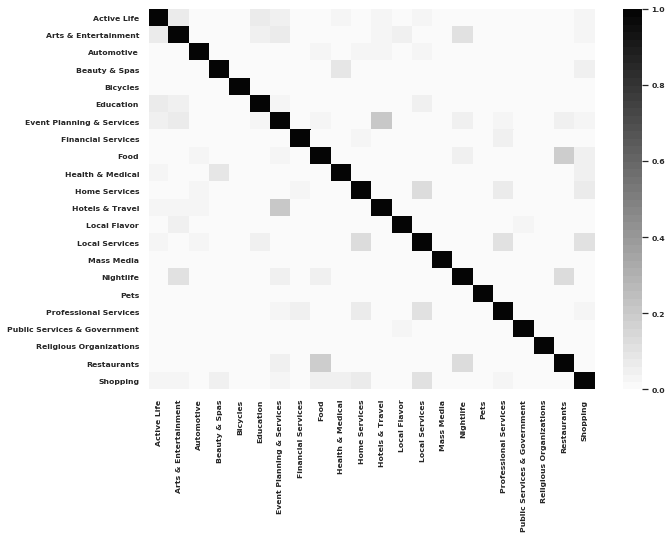

In [57]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}, cmap=sn.color_palette("binary", 50)) # font size
plt.show()

<Figure size 1152x1152 with 0 Axes>

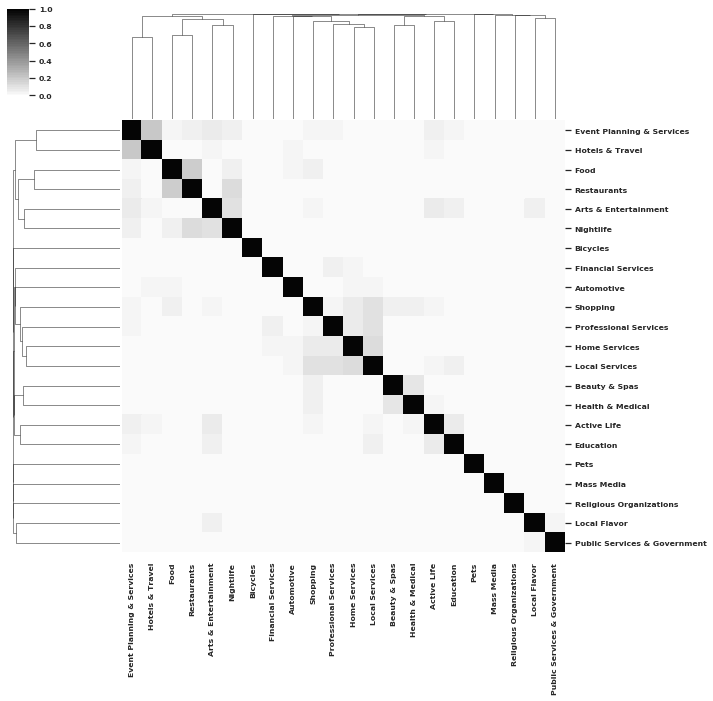

In [58]:
plt.figure(figsize = (16, 16))
sn.set(font_scale=0.7) # for label size
# pal = sn.dark_palette("palegreen", as_cmap=True, reverse=True)
pal = sn.color_palette("binary", 50)  # PuBu - BuGn - RdPu - Greys
sn.clustermap(df_cm, annot_kws={"size": 5}, cmap=pal)  # cmap="vlag") # plt.cm.Blues)

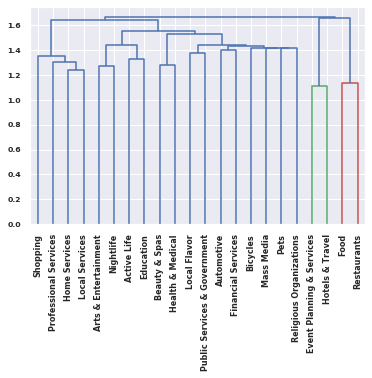

In [59]:
Z = hierarchy.linkage(df_cm, "ward")
#hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

---

##### Test filter : load single and filter others

In [ ]:
df_food = load_cached_root_category_businesses_df("Food", map_categories)
# df_food = get_reviews_for_category(df, "Food", inv_cat_bids, map_categories, map_cat_name2id)

df_uniq_food = filter_root_category_businesses_uniq("Food", inv_cat_bids, map_categories, map_cat_name2id)

len(df), len(df_food), len(df_uniq_food)

---

In [ ]:
cat_name = "Food"
# cat_name = "Public Services & Government"

df_food = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df_food = filter_min_review_freq(df_food, min_ratings=5)

In [ ]:
tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

df_food = df_food.progress_apply(tokenize_text, axis=1)

In [ ]:
def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

df_food = df_food.progress_apply(count_words, axis=1)

In [ ]:
df_food.info()

In [ ]:
df_food.describe()

In [ ]:
df_food["num_words"].mean()

In [ ]:
cat_name, df_food["num_words"].mean()

In [ ]:
root_category_labels

In [ ]:
df_roots = list()

tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

for root_category_label in root_category_labels:
    df_rootcat = get_reviews_for_category(df, root_category_label, inv_cat_bids, map_categories, map_cat_name2id)
    
    df_rootcat = filter_min_review_freq(df_rootcat, min_ratings=5)

    df_rootcat = df_rootcat.progress_apply(tokenize_text, axis=1)
    
    df_rootcat = df_rootcat.progress_apply(count_words, axis=1)
    
    # df_roots.append(df_rootcat)
    print(f"""{root_category_label}: {df_rootcat["num_words"].mean()}""")

In [ ]:
for root_category_label, df_rootcat in zip(root_category_labels, df_roots):
    print(f"""{root_category_label}: {df_rootcat["num_words"].mean()}""")

In [ ]:
import pickle

fn_root_cat_reviews = data_yelp_path / "df_root_cat_reviews.p"

with open(fn_root_cat_reviews, "wb") as fp:
    pickle.dump(root_category_labels, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(df_roots, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

---

---

### Filter all reviews - can only contain top50 Topics

In [ ]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
f_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats)
f_inv_cat_bids = make_map_cats(f_inv_bid_cats)
f_inv_cat_combis = make_cat_combis(f_inv_bid_cats)
f_cat_pairs = make_cat_Ntuples(f_inv_cat_combis, n=2)

### Filter with minimum number of category combination occurrences

In [ ]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
# f_cats = None

avg_num_of_cat_combis = int(sum(list(f_inv_cat_combis.values())) / len(f_inv_cat_combis))
fi_inv_cat_combis = filter_min_cat_combis(inv_cat_combis, min_num=30)

f2_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats, filter_cat_combis=fi_inv_cat_combis)

f2_inv_cat_bids = make_map_cats(f2_inv_bid_cats)
f2_inv_cat_combis = make_cat_combis(f2_inv_bid_cats)
f2_cat_pairs = make_cat_Ntuples(f2_inv_cat_combis, n=2)

### Make NxN map and heatmap it

In [ ]:
df_cm, cat_array, cat_labels = make_NxN_map(f_cats, f2_cat_pairs)

#### Clustering

In [ ]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}) # font size
plt.show()

In [ ]:
plt.figure(figsize = (16, 16))
sn.set(font_scale=0.7) # for label size
# pal = sn.dark_palette("palegreen", as_cmap=True, reverse=True)
pal = sn.color_palette("binary", 10)  # PuBu - BuGn - RdPu - Greys
sn.clustermap(df_cm, annot_kws={"size": 5}, cmap=pal)  # cmap="vlag") # plt.cm.Blues)

In [ ]:
Z = hierarchy.linkage(df_cm, "ward")
#hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

In [ ]:
df_cm2 = ssd.squareform(df_cm)

Z = hierarchy.linkage(df_cm2, "ward")
hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

In [ ]:
sc = SpectralClustering(5, affinity='precomputed', n_init=100, assign_labels='discretize')
cluster_labels = sc.fit_predict(cat_array)

# sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

In [ ]:
ac = AgglomerativeClustering(4, affinity='euclidean', linkage='ward')
csarr = cosine_similarity(cat_array)
cluster_labels = ac.fit_predict(csarr)

# sorted(list(zip(labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

In [ ]:
# cat_array, \
# linear_kernel(cat_array), \
# cosine_similarity(cat_array), \
# cat_labels

### Stats for `cat_labels` in filtered category maps/lists etc.

In [ ]:
# number of business ids given a specific category
sorted([(c, len(f_inv_cat_bids[c])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f2_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# better with filtering
# category pairs for a given category
sorted([(c, [cc for cc in f2_cat_pairs.keys() if c in cc]) for c in cat_labels], key=lambda x: len(x[1]), reverse=True)[:5]

In [ ]:
# category pairs for a category:
c = "Food"

print("filtered by top50\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f_cat_pairs.keys() if c in cc]])
print()
print("filtered by avg amount (+top50)\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f2_cat_pairs.keys() if c in cc]])

In [ ]:
f2_inv_cat_combis[("Food",)]  # businesses with only this category ... (filtering should not affect this value)

In [ ]:
f2_inv_cat_combis

In [ ]:
inv_bid_cats = f2_inv_bid_cats
inv_cat_bids = f2_inv_cat_bids
inv_cat_combis = f2_inv_cat_combis
cat_pairs = f2_cat_pairs

In [ ]:
sum([len(b) for a, b in f2_inv_cat_bids.items()])

In [ ]:
inv_bid_cats = load_topics(fn_yelp_topics)
sum([len(b) for a, b in inv_cat_bids.items()])

In [ ]:
https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
len(f2_inv_cat_combis)  # number of category combinations

---

#### Statistics

In [ ]:
print(f"Number of businesses with categories: {len(inv_bid_cats):>6}")
print(f"                  without categories: {len(bids_not_cats):>6}")
print(f"Number of categories: len(inv_cat_bids) = {len(inv_cat_bids)}")

In [ ]:
inv_cat_combis.most_common(20)

In [ ]:
# count single categories
cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
cnt.most_common(20)

#### Filter reviews with at least N ratings

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df = filter_min_review_freq(df, min_ratings=5)

#### Filter only reviews with both good and bad rating

In [ ]:
df = filter_both_good_bad(df)

#### Make pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [ ]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [ ]:
pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)

print("#ss (pos)", len(pairs_good))
print("#ss (neg)", len(pairs_bad))

##### not same-sentiment pairs (combinations positive + negative)

In [ ]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [ ]:
pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)

print("#nss", len(pairs_not_ss))

##### dataframe for training etc.

In [ ]:
pairs_all = pairs_good + pairs_bad + pairs_not_ss
print("#~ss", len(pairs_all))

# print(pairs_all[0]["argument1_id"])
np.random.shuffle(pairs_all)
# print(pairs_all[0]["argument1_id"])

df_traindev = pd.DataFrame.from_dict(pairs_all)

In [ ]:
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "wb") as fp:
    pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

#### Reloading for training

In [ ]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [ ]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

In [ ]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

In [ ]:
# len(traindev_df), len(test_df)

---
---
---

## Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
# ! pip install --upgrade 'mxnet>=1.3.0'
# NOTE: do not install cpu + gpu version both, only one!
! pip install --upgrade mxnet-cu102
! pip install --upgrade gluonnlp 

In [ ]:
! wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
# ! unzip sentence_embedding.zip
# ! ln -s sentence_embedding/bert bert

In [32]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix
from utils_gluon import compute_metrics

from utils_data import names_columns_X_arteval, names_columns_y

In [33]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

---

In [34]:
run_name = "yelp_3_arts_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "Arts & Entertainment"

! mkdir data/yelp_3_arts_pro128BCE

---

In [35]:
df_food = load_cached_root_category_businesses_df(category_name, map_categories)
# df_food = get_reviews_for_category(df, category_name, inv_cat_bids, map_categories, map_cat_name2id)

df_uniq_food = filter_root_category_businesses_uniq(category_name, inv_cat_bids, map_categories, map_cat_name2id)

len(df), len(df_food), len(df_uniq_food)

Filter businesses from category Active Life [active] (9521 businesses) ...
Filtered 54847 businesses (overlap with Active Life)
Filter businesses from category Automotive [auto] (13203 businesses) ...
Filtered 6197 businesses (overlap with Automotive)
Filter businesses from category Beauty & Spas [beautysvc] (19370 businesses) ...
Filtered 18906 businesses (overlap with Beauty & Spas)
Filter businesses from category Bicycles [bicycles] (9 businesses) ...
Filtered 0 businesses (overlap with Bicycles)
Filter businesses from category Education [education] (3314 businesses) ...
Filtered 7720 businesses (overlap with Education)
Filter businesses from category Event Planning & Services [eventservices] (10371 businesses) ...
Filtered 131334 businesses (overlap with Event Planning & Services)
Filter businesses from category Financial Services [financialservices] (3082 businesses) ...
Filtered 32 businesses (overlap with Financial Services)
Filter businesses from category Food [food] (29989 bus

(6685900, 417708, 48899)

In [36]:
df_td = df_uniq_food

In [37]:
# min ratings per class (good|bad)
min_ratings = 5

df_td = filter_min_review_freq(df_td, min_ratings=5)

In [38]:
df_td = filter_both_good_bad(df_td)

In [39]:
traindev_df = make_or_load_pairs(df_td, str(fn_traindev_df), num_pairs_per_class=2)

  5%|▌         | 21/415 [00:00<00:01, 203.46it/s]

#ss (pos) 830
#ss (neg) 830


100%|██████████| 415/415 [00:02<00:00, 203.66it/s]

#nss 1660
#~ss 3320


In [40]:
len(traindev_df)  # pairs

3320

---

In [41]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
traindev_df["tag"] = "NA"

In [42]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(traindev_df, ratio=0.1)

In [43]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=0)

Start on [setup BERT model] ...
Time for [setup BERT model]: 0:00:06.735869


In [44]:
with Timer("prepare training / validation data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:00.477598


In [45]:
num_epochs = 3
batch_size = 32

##### Training with TRAIN set

  0%|          | 13/2988 [00:00<00:22, 129.39it/s]

Start on [train model - 0] ...
Start on [setup training] ...


  0%|          | 0/99 [00:00<?, ?it/s]

Time for [setup training]: 0:00:24.121730
Start on [training] ...
Start on [epoch 0] ...


  1%|          | 1/99 [00:01<02:40,  1.64s/it]2020-05-11 11:24:48,753 : INFO : successfully opened events file: data/yelp_3_arts_pro128BCE/events.out.tfevents.1589189088.cuda
2020-05-11 11:24:48,754 : INFO : wrote 1 event to disk
2020-05-11 11:24:48,755 : INFO : wrote 1 event to disk
100%|██████████| 99/99 [01:37<00:00,  1.16it/s]


Time for [epoch 0]: 0:01:37.047231


  0%|          | 0/99 [00:00<?, ?it/s]

Start on [epoch 1] ...


100%|██████████| 99/99 [01:38<00:00,  1.05s/it]


Time for [epoch 1]: 0:01:38.038662


  0%|          | 0/99 [00:00<?, ?it/s]

Start on [epoch 2] ...


100%|██████████| 99/99 [01:37<00:00,  1.01it/s]


Time for [epoch 2]: 0:01:37.961973
Time for [training]: 0:05:09.037167


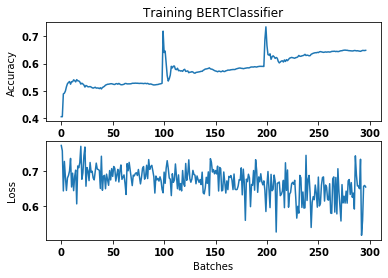

2020-05-11 11:29:56,549 : INFO : wrote 593 events to disk
  0%|          | 0/11 [00:00<?, ?it/s]

Time for [train model - 0]: 0:05:33.573823
Start on [evaluate - 0] ...
Start on [prediction] ...


  9%|▉         | 1/11 [00:00<00:04,  2.10it/s]2020-05-11 11:29:57,045 : INFO : successfully opened events file: data/yelp_3_arts_pro128BCE/events.out.tfevents.1589189397.cuda
2020-05-11 11:29:57,056 : INFO : wrote 1 event to disk
2020-05-11 11:29:57,057 : INFO : wrote 1 event to disk
100%|██████████| 11/11 [00:04<00:00,  2.72it/s]
2020-05-11 11:30:00,994 : INFO : wrote 21 events to disk


Time for [prediction]: 0:00:04.418660
Accuracy in epoch 0: 0.6174698795180723
Confusion Matrix:
[[114  48]
 [ 79  91]]

CM: [114  48  79  91] 
[tn, fp, fn, tp]
  accuracy: 0.617
 precision: 0.623
    recall: 0.619
  f1-score: 0.616

Accuracy:  0.617 

Report for [BERTClassifier - yelp_3_arts_pro128BCE]:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       162
           1       0.65      0.54      0.59       170

    accuracy                           0.62       332
   macro avg       0.62      0.62      0.62       332
weighted avg       0.62      0.62      0.61       332

Time for [evaluate - 0]: 0:00:04.445577


  1%|          | 19/2988 [00:00<00:15, 185.65it/s]

Start on [train model - 1] ...
Start on [setup training] ...


100%|██████████| 2988/2988 [00:23<00:00, 126.22it/s]


Time for [setup training]: 0:00:23.703052
Start on [training] ...
loaded checkpoint for epoch 0


  0%|          | 0/11 [00:00<?, ?it/s]

loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
Time for [training]: 0:00:00.622071
no stats to plot
Time for [train model - 1]: 0:00:24.353548
Start on [evaluate - 1] ...
Start on [prediction] ...


  9%|▉         | 1/11 [00:00<00:04,  2.14it/s]2020-05-11 11:30:32,220 : INFO : successfully opened events file: data/yelp_3_arts_pro128BCE/events.out.tfevents.1589189432.cuda
2020-05-11 11:30:32,221 : INFO : wrote 1 event to disk
2020-05-11 11:30:32,222 : INFO : wrote 1 event to disk
100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
2020-05-11 11:30:36,447 : INFO : wrote 21 events to disk


Time for [prediction]: 0:00:04.684937
Accuracy in epoch 1: 0.6174698795180723
Confusion Matrix:
[[114  48]
 [ 79  91]]

CM: [114  48  79  91] 
[tn, fp, fn, tp]
  accuracy: 0.617
 precision: 0.623
    recall: 0.619
  f1-score: 0.616

Accuracy:  0.617 

Report for [BERTClassifier - yelp_3_arts_pro128BCE]:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       162
           1       0.65      0.54      0.59       170

    accuracy                           0.62       332
   macro avg       0.62      0.62      0.62       332
weighted avg       0.62      0.62      0.61       332

Time for [evaluate - 1]: 0:00:04.742364


  0%|          | 9/2988 [00:00<00:34, 87.03it/s]

Start on [train model - 2] ...
Start on [setup training] ...


100%|██████████| 2988/2988 [00:21<00:00, 135.92it/s]


Time for [setup training]: 0:00:21.998988
Start on [training] ...
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1


  0%|          | 0/11 [00:00<?, ?it/s]

loaded checkpoint for epoch 2
Time for [training]: 0:00:00.891330
no stats to plot
Time for [train model - 2]: 0:00:22.896107
Start on [evaluate - 2] ...
Start on [prediction] ...


  9%|▉         | 1/11 [00:00<00:04,  2.21it/s]2020-05-11 11:31:06,910 : INFO : successfully opened events file: data/yelp_3_arts_pro128BCE/events.out.tfevents.1589189466.cuda
2020-05-11 11:31:06,930 : INFO : wrote 1 event to disk
2020-05-11 11:31:06,931 : INFO : wrote 1 event to disk
100%|██████████| 11/11 [00:04<00:00,  2.73it/s]
2020-05-11 11:31:10,617 : INFO : wrote 21 events to disk


Time for [prediction]: 0:00:04.151284
Accuracy in epoch 2: 0.6174698795180723
Confusion Matrix:
[[114  48]
 [ 79  91]]

CM: [114  48  79  91] 
[tn, fp, fn, tp]
  accuracy: 0.617
 precision: 0.623
    recall: 0.619
  f1-score: 0.616

Accuracy:  0.617 

Report for [BERTClassifier - yelp_3_arts_pro128BCE]:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       162
           1       0.65      0.54      0.59       170

    accuracy                           0.62       332
   macro avg       0.62      0.62      0.62       332
weighted avg       0.62      0.62      0.61       332

Time for [evaluate - 2]: 0:00:04.180791


In [46]:
for epoch_id in range(num_epochs):
    with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)

    with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

    model.save_parameters(str(fn_run_path / "bert.model.params"))

In [ ]:
plot_train_stats(stats)

##### Results with validation set (DEV set)

  0%|          | 0/11 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 11/11 [00:04<00:00,  3.01it/s]


Time for [prediction]: 0:00:04.350323
Confusion Matrix:
[[114  48]
 [ 79  91]]

CM: [114  48  79  91] 
[tn, fp, fn, tp]
  accuracy: 0.617
 precision: 0.623
    recall: 0.619
  f1-score: 0.616

Accuracy:  0.617 

Report for [BERTClassifier - yelp_3_arts_pro128BCE]:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       162
           1       0.65      0.54      0.59       170

    accuracy                           0.62       332
   macro avg       0.62      0.62      0.62       332
weighted avg       0.62      0.62      0.61       332



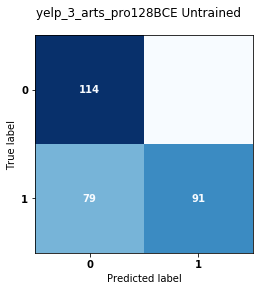

In [47]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

Evaluate trained model for each epoch ...
Load data/yelp_3_arts_pro128BCE/bert.model.checkpoint0.params ...


  0%|          | 0/11 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


Time for [prediction]: 0:00:03.878943
Confusion Matrix:
[[ 67  95]
 [ 56 114]]

CM: [ 67  95  56 114] 
[tn, fp, fn, tp]
  accuracy: 0.545
 precision: 0.545
    recall: 0.542
  f1-score: 0.536

Accuracy:  0.545 

Report for [BERTClassifier - yelp_3_arts_pro128BCE]:
              precision    recall  f1-score   support

           0       0.54      0.41      0.47       162
           1       0.55      0.67      0.60       170

    accuracy                           0.55       332
   macro avg       0.55      0.54      0.54       332
weighted avg       0.55      0.55      0.54       332



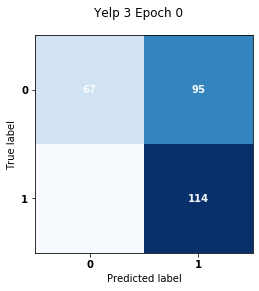

Load data/yelp_3_arts_pro128BCE/bert.model.checkpoint1.params ...


  0%|          | 0/11 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Time for [prediction]: 0:00:04.985855
Confusion Matrix:
[[120  42]
 [104  66]]

CM: [120  42 104  66] 
[tn, fp, fn, tp]
  accuracy: 0.560
 precision: 0.573
    recall: 0.564
  f1-score: 0.548

Accuracy:  0.56 

Report for [BERTClassifier - yelp_3_arts_pro128BCE]:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       162
           1       0.61      0.39      0.47       170

    accuracy                           0.56       332
   macro avg       0.57      0.56      0.55       332
weighted avg       0.57      0.56      0.55       332



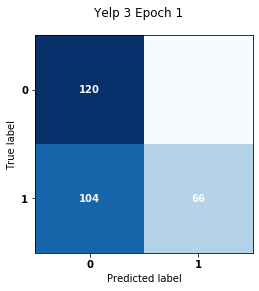

Load data/yelp_3_arts_pro128BCE/bert.model.checkpoint2.params ...


  0%|          | 0/11 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 11/11 [00:04<00:00,  2.94it/s]


Time for [prediction]: 0:00:04.432767
Confusion Matrix:
[[114  48]
 [ 79  91]]

CM: [114  48  79  91] 
[tn, fp, fn, tp]
  accuracy: 0.617
 precision: 0.623
    recall: 0.619
  f1-score: 0.616

Accuracy:  0.617 

Report for [BERTClassifier - yelp_3_arts_pro128BCE]:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       162
           1       0.65      0.54      0.59       170

    accuracy                           0.62       332
   macro avg       0.62      0.62      0.62       332
weighted avg       0.62      0.62      0.61       332



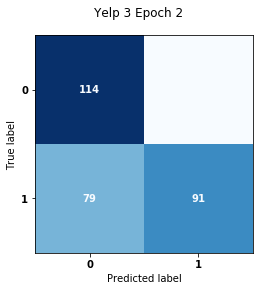

In [48]:
print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 3 Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

### Load other categories and evaluate

In [49]:
fn_model_state = fn_run_path / f"bert.model.checkpoint{num_epochs - 1}.params"
print(f"Load {fn_model_state} ...")
model.load_parameters(str(fn_model_state), ctx=ctx)

Load data/yelp_3_arts_pro128BCE/bert.model.checkpoint2.params ...


In [50]:
# lst_root_categories
root_categories = get_root_category_items(map_categories)
root_categories = sorted(root_categories, key=lambda x: x["title"])
root_category_labels = [x["title"] for x in root_categories]

Work on Active Life ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 54847 businesses (overlap with Arts & Entertainment)


  0%|          | 0/1683 [00:00<?, ?it/s]

#ss (pos) 3366
#ss (neg) 3366


100%|██████████| 1683/1683 [00:07<00:00, 235.74it/s]


#nss 6732
#~ss 13464
review pairs: 13464


  0%|          | 0/421 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 421/421 [03:00<00:00,  2.52it/s]


Time for [prediction]: 0:03:00.835825
Confusion Matrix:
[[4555 2177]
 [2386 4346]]

CM: [4555 2177 2386 4346] 
[tn, fp, fn, tp]
  accuracy: 0.661
 precision: 0.661
    recall: 0.661
  f1-score: 0.661

Accuracy:  0.661 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Active Life]:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      6732
           1       0.67      0.65      0.66      6732

    accuracy                           0.66     13464
   macro avg       0.66      0.66      0.66     13464
weighted avg       0.66      0.66      0.66     13464



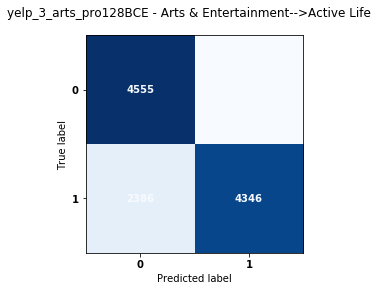

Work on Automotive ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 7067 businesses (overlap with Arts & Entertainment)


  0%|          | 0/2829 [00:00<?, ?it/s]

#ss (pos) 5658
#ss (neg) 5658


100%|██████████| 2829/2829 [00:13<00:00, 217.02it/s]


#nss 11316
#~ss 22632
review pairs: 22632


  0%|          | 0/708 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 708/708 [04:57<00:00,  2.66it/s]


Time for [prediction]: 0:04:57.945813
Confusion Matrix:
[[7544 3772]
 [3171 8145]]

CM: [7544 3772 3171 8145] 
[tn, fp, fn, tp]
  accuracy: 0.693
 precision: 0.694
    recall: 0.693
  f1-score: 0.693

Accuracy:  0.693 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Automotive]:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68     11316
           1       0.68      0.72      0.70     11316

    accuracy                           0.69     22632
   macro avg       0.69      0.69      0.69     22632
weighted avg       0.69      0.69      0.69     22632



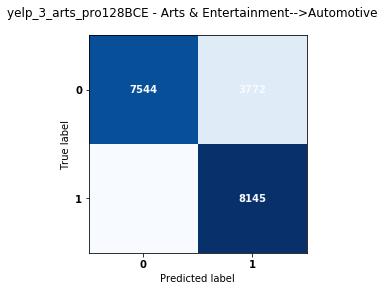

Work on Beauty & Spas ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 20972 businesses (overlap with Arts & Entertainment)


100%|██████████| 4944/4944 [00:22<00:00, 219.46it/s]


#ss (pos) 9888
#ss (neg) 9888


100%|██████████| 4944/4944 [00:20<00:00, 246.05it/s]


#nss 19776
#~ss 39552
review pairs: 39552


  0%|          | 0/1236 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1236/1236 [08:15<00:00,  2.55it/s]


Time for [prediction]: 0:08:15.651335
Confusion Matrix:
[[13438  6338]
 [ 4977 14799]]

CM: [13438  6338  4977 14799] 
[tn, fp, fn, tp]
  accuracy: 0.714
 precision: 0.715
    recall: 0.714
  f1-score: 0.714

Accuracy:  0.714 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70     19776
           1       0.70      0.75      0.72     19776

    accuracy                           0.71     39552
   macro avg       0.71      0.71      0.71     39552
weighted avg       0.71      0.71      0.71     39552



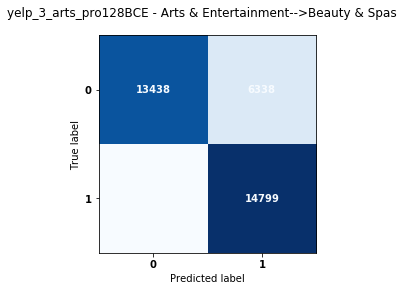

  0%|          | 0/1 [00:00<?, ?it/s]

Work on Bicycles ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 0 businesses (overlap with Arts & Entertainment)
#ss (pos) 2
#ss (neg) 2
#nss 4
#~ss 8
review pairs: 8
Start on [prediction] ...


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Time for [prediction]: 0:00:00.122218
Confusion Matrix:
[[2 2]
 [3 1]]

CM: [2 2 3 1] 
[tn, fp, fn, tp]
  accuracy: 0.375
 precision: 0.367
    recall: 0.375
  f1-score: 0.365

Accuracy:  0.375 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Bicycles]:
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.33      0.25      0.29         4

    accuracy                           0.38         8
   macro avg       0.37      0.38      0.37         8
weighted avg       0.37      0.38      0.37         8



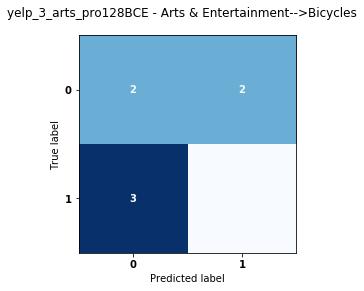

Work on Education ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 10659 businesses (overlap with Arts & Entertainment)


  5%|▌         | 19/371 [00:00<00:01, 189.38it/s]

#ss (pos) 742
#ss (neg) 742


100%|██████████| 371/371 [00:01<00:00, 214.01it/s]


#nss 1484
#~ss 2968
review pairs: 2968


  0%|          | 0/93 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 93/93 [00:44<00:00,  2.41it/s]


Time for [prediction]: 0:00:44.760396
Confusion Matrix:
[[ 984  500]
 [ 462 1022]]

CM: [ 984  500  462 1022] 
[tn, fp, fn, tp]
  accuracy: 0.676
 precision: 0.676
    recall: 0.676
  f1-score: 0.676

Accuracy:  0.676 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Education]:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1484
           1       0.67      0.69      0.68      1484

    accuracy                           0.68      2968
   macro avg       0.68      0.68      0.68      2968
weighted avg       0.68      0.68      0.68      2968



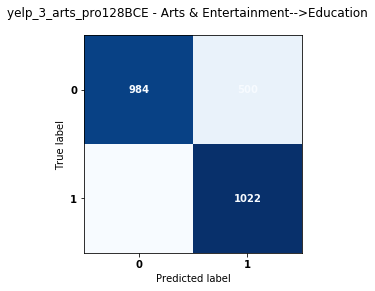

Work on Event Planning & Services ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 178906 businesses (overlap with Arts & Entertainment)


100%|██████████| 3200/3200 [00:15<00:00, 200.22it/s]


#ss (pos) 6400
#ss (neg) 6400


100%|██████████| 3200/3200 [00:14<00:00, 216.27it/s]


#nss 12800
#~ss 25600
review pairs: 25600


  0%|          | 0/800 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 800/800 [05:43<00:00,  2.25it/s]


Time for [prediction]: 0:05:43.054392
Confusion Matrix:
[[8209 4591]
 [4390 8410]]

CM: [8209 4591 4390 8410] 
[tn, fp, fn, tp]
  accuracy: 0.649
 precision: 0.649
    recall: 0.649
  f1-score: 0.649

Accuracy:  0.649 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Event Planning & Services]:
              precision    recall  f1-score   support

           0       0.65      0.64      0.65     12800
           1       0.65      0.66      0.65     12800

    accuracy                           0.65     25600
   macro avg       0.65      0.65      0.65     25600
weighted avg       0.65      0.65      0.65     25600



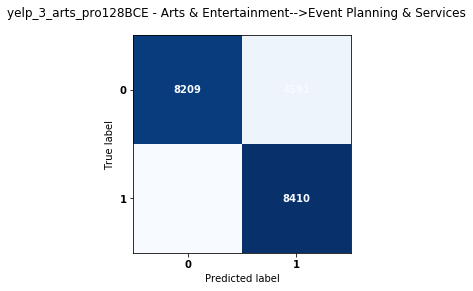

  0%|          | 0/295 [00:00<?, ?it/s]

Work on Financial Services ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 305 businesses (overlap with Arts & Entertainment)


  8%|▊         | 25/295 [00:00<00:01, 241.54it/s]

#ss (pos) 590
#ss (neg) 590


100%|██████████| 295/295 [00:01<00:00, 275.07it/s]


#nss 1180
#~ss 2360
review pairs: 2360


  0%|          | 0/74 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 74/74 [00:28<00:00,  2.61it/s]

Time for [prediction]: 0:00:28.697304
Confusion Matrix:
[[810 370]
 [294 886]]

CM: [810 370 294 886] 
[tn, fp, fn, tp]
  accuracy: 0.719
 precision: 0.720
    recall: 0.719
  f1-score: 0.718

Accuracy:  0.719 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Financial Services]:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1180
           1       0.71      0.75      0.73      1180

    accuracy                           0.72      2360
   macro avg       0.72      0.72      0.72      2360
weighted avg       0.72      0.72      0.72      2360



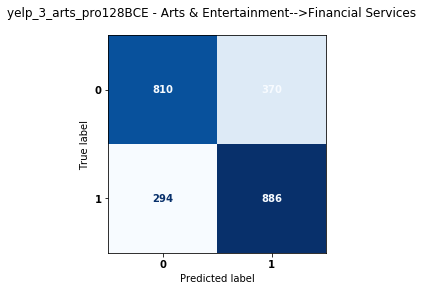

Work on Food ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 53758 businesses (overlap with Arts & Entertainment)


100%|██████████| 12486/12486 [01:00<00:00, 207.25it/s]


#ss (pos) 24972
#ss (neg) 24972


100%|██████████| 12486/12486 [00:54<00:00, 227.76it/s]


#nss 49944
#~ss 99888
review pairs: 99888


  0%|          | 0/3122 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 3122/3122 [19:49<00:00,  3.49it/s]


Time for [prediction]: 0:19:49.869127
Confusion Matrix:
[[31446 18498]
 [17336 32608]]

CM: [31446 18498 17336 32608] 
[tn, fp, fn, tp]
  accuracy: 0.641
 precision: 0.641
    recall: 0.641
  f1-score: 0.641

Accuracy:  0.641 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Food]:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64     49944
           1       0.64      0.65      0.65     49944

    accuracy                           0.64     99888
   macro avg       0.64      0.64      0.64     99888
weighted avg       0.64      0.64      0.64     99888



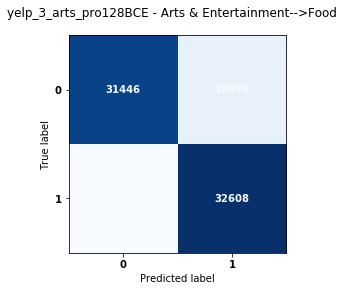

Work on Health & Medical ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 1933 businesses (overlap with Arts & Entertainment)


100%|██████████| 3167/3167 [00:13<00:00, 239.18it/s]


#ss (pos) 6334
#ss (neg) 6334


100%|██████████| 3167/3167 [00:13<00:00, 234.64it/s]


#nss 12668
#~ss 25336
review pairs: 25336


  0%|          | 0/792 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 792/792 [07:50<00:00,  1.67it/s]


Time for [prediction]: 0:07:50.152600
Confusion Matrix:
[[8348 4320]
 [3037 9631]]

CM: [8348 4320 3037 9631] 
[tn, fp, fn, tp]
  accuracy: 0.710
 precision: 0.712
    recall: 0.710
  f1-score: 0.709

Accuracy:  0.71 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Health & Medical]:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69     12668
           1       0.69      0.76      0.72     12668

    accuracy                           0.71     25336
   macro avg       0.71      0.71      0.71     25336
weighted avg       0.71      0.71      0.71     25336



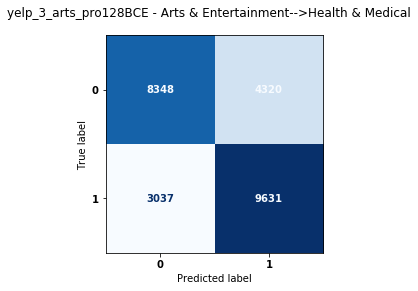

Work on Home Services ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 4354 businesses (overlap with Arts & Entertainment)


100%|██████████| 3070/3070 [00:14<00:00, 209.40it/s]


#ss (pos) 6140
#ss (neg) 6140


100%|██████████| 3070/3070 [00:14<00:00, 210.52it/s]


#nss 12280
#~ss 24560
review pairs: 24560


  0%|          | 0/768 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 768/768 [05:50<00:00,  2.85it/s]


Time for [prediction]: 0:05:50.592238
Confusion Matrix:
[[7993 4287]
 [2900 9380]]

CM: [7993 4287 2900 9380] 
[tn, fp, fn, tp]
  accuracy: 0.707
 precision: 0.710
    recall: 0.707
  f1-score: 0.706

Accuracy:  0.707 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Home Services]:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     12280
           1       0.69      0.76      0.72     12280

    accuracy                           0.71     24560
   macro avg       0.71      0.71      0.71     24560
weighted avg       0.71      0.71      0.71     24560



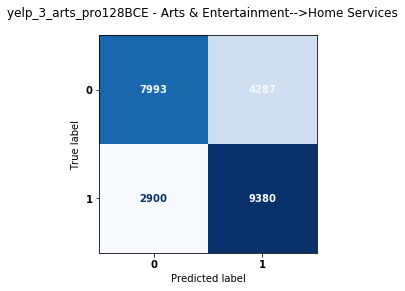

Work on Hotels & Travel ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 138341 businesses (overlap with Arts & Entertainment)


100%|██████████| 2013/2013 [00:09<00:00, 222.72it/s]


#ss (pos) 4026
#ss (neg) 4026


100%|██████████| 2013/2013 [00:08<00:00, 237.78it/s]


#nss 8052
#~ss 16104
review pairs: 16104


  0%|          | 0/504 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 504/504 [03:47<00:00,  2.53it/s]


Time for [prediction]: 0:03:47.831880
Confusion Matrix:
[[5319 2733]
 [2719 5333]]

CM: [5319 2733 2719 5333] 
[tn, fp, fn, tp]
  accuracy: 0.661
 precision: 0.661
    recall: 0.661
  f1-score: 0.661

Accuracy:  0.661 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Hotels & Travel]:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      8052
           1       0.66      0.66      0.66      8052

    accuracy                           0.66     16104
   macro avg       0.66      0.66      0.66     16104
weighted avg       0.66      0.66      0.66     16104



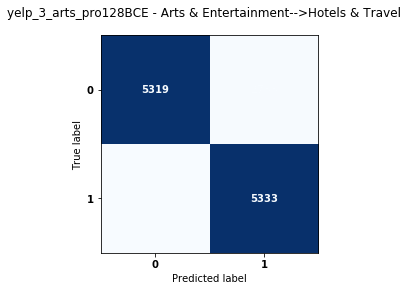

Work on Local Flavor ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 33475 businesses (overlap with Arts & Entertainment)


  4%|▍         | 14/369 [00:00<00:02, 139.37it/s]

#ss (pos) 738
#ss (neg) 738


100%|██████████| 369/369 [00:02<00:00, 175.24it/s]


#nss 1476
#~ss 2952
review pairs: 2952


  0%|          | 0/93 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 93/93 [00:35<00:00,  3.71it/s]


Time for [prediction]: 0:00:35.814014
Confusion Matrix:
[[933 543]
 [535 941]]

CM: [933 543 535 941] 
[tn, fp, fn, tp]
  accuracy: 0.635
 precision: 0.635
    recall: 0.635
  f1-score: 0.635

Accuracy:  0.635 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Local Flavor]:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1476
           1       0.63      0.64      0.64      1476

    accuracy                           0.63      2952
   macro avg       0.63      0.63      0.63      2952
weighted avg       0.63      0.63      0.63      2952



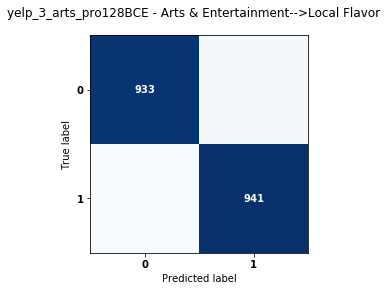

Work on Local Services ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 5008 businesses (overlap with Arts & Entertainment)


  0%|          | 0/2287 [00:00<?, ?it/s]

#ss (pos) 4574
#ss (neg) 4574


100%|██████████| 2287/2287 [00:09<00:00, 241.73it/s]


#nss 9148
#~ss 18296
review pairs: 18296


  0%|          | 0/572 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 572/572 [03:54<00:00,  2.42it/s]


Time for [prediction]: 0:03:54.675026
Confusion Matrix:
[[5951 3197]
 [2376 6772]]

CM: [5951 3197 2376 6772] 
[tn, fp, fn, tp]
  accuracy: 0.695
 precision: 0.697
    recall: 0.695
  f1-score: 0.695

Accuracy:  0.695 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Local Services]:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      9148
           1       0.68      0.74      0.71      9148

    accuracy                           0.70     18296
   macro avg       0.70      0.70      0.69     18296
weighted avg       0.70      0.70      0.69     18296



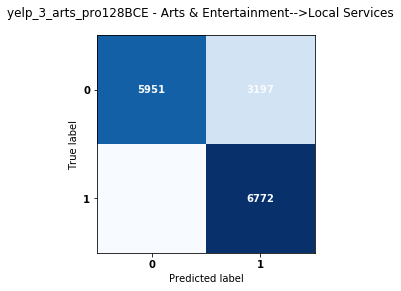

  0%|          | 0/34 [00:00<?, ?it/s]

Work on Mass Media ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 237 businesses (overlap with Arts & Entertainment)


 44%|████▍     | 15/34 [00:00<00:00, 132.03it/s]

#ss (pos) 68
#ss (neg) 68


  0%|          | 0/9 [00:00<?, ?it/s]

#nss 136
#~ss 272
review pairs: 272
Start on [prediction] ...


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

Time for [prediction]: 0:00:03.918802
Confusion Matrix:
[[100  36]
 [ 46  90]]

CM: [100  36  46  90] 
[tn, fp, fn, tp]
  accuracy: 0.699
 precision: 0.700
    recall: 0.699
  f1-score: 0.698

Accuracy:  0.699 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Mass Media]:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       136
           1       0.71      0.66      0.69       136

    accuracy                           0.70       272
   macro avg       0.70      0.70      0.70       272
weighted avg       0.70      0.70      0.70       272



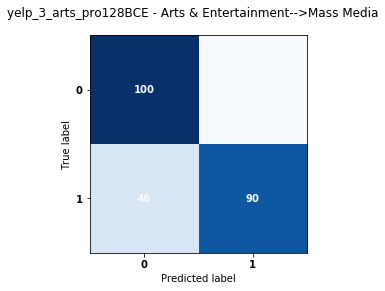

Work on Nightlife ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 173152 businesses (overlap with Arts & Entertainment)


100%|██████████| 7109/7109 [00:32<00:00, 218.95it/s]


#ss (pos) 14218
#ss (neg) 14218


100%|██████████| 7109/7109 [00:31<00:00, 228.44it/s]


#nss 28436
#~ss 56872
review pairs: 56872


  0%|          | 0/1778 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1778/1778 [11:44<00:00,  2.55it/s]


Time for [prediction]: 0:11:44.933560
Confusion Matrix:
[[18605  9831]
 [10777 17659]]

CM: [18605  9831 10777 17659] 
[tn, fp, fn, tp]
  accuracy: 0.638
 precision: 0.638
    recall: 0.638
  f1-score: 0.638

Accuracy:  0.638 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Nightlife]:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     28436
           1       0.64      0.62      0.63     28436

    accuracy                           0.64     56872
   macro avg       0.64      0.64      0.64     56872
weighted avg       0.64      0.64      0.64     56872



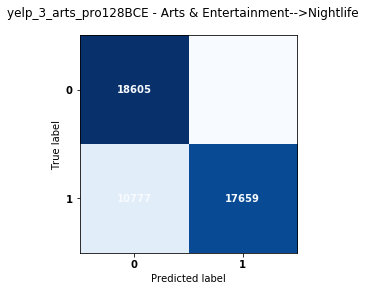

Work on Pets ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 1110 businesses (overlap with Arts & Entertainment)


  0%|          | 0/989 [00:00<?, ?it/s]

#ss (pos) 1978
#ss (neg) 1978


100%|██████████| 989/989 [00:04<00:00, 242.59it/s]


#nss 3956
#~ss 7912
review pairs: 7912


  0%|          | 0/248 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 248/248 [01:52<00:00,  2.83it/s]


Time for [prediction]: 0:01:52.058610
Confusion Matrix:
[[2673 1283]
 [1177 2779]]

CM: [2673 1283 1177 2779] 
[tn, fp, fn, tp]
  accuracy: 0.689
 precision: 0.689
    recall: 0.689
  f1-score: 0.689

Accuracy:  0.689 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Pets]:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      3956
           1       0.68      0.70      0.69      3956

    accuracy                           0.69      7912
   macro avg       0.69      0.69      0.69      7912
weighted avg       0.69      0.69      0.69      7912



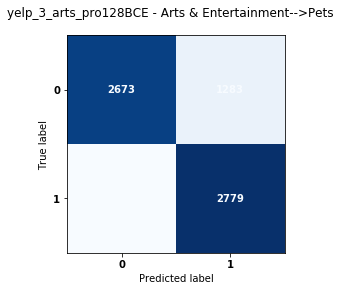

Work on Professional Services ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 9741 businesses (overlap with Arts & Entertainment)


  4%|▎         | 25/687 [00:00<00:02, 247.37it/s]

#ss (pos) 1374
#ss (neg) 1374


100%|██████████| 687/687 [00:02<00:00, 243.03it/s]


#nss 2748
#~ss 5496
review pairs: 5496


  0%|          | 0/172 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 172/172 [01:10<00:00,  2.47it/s]


Time for [prediction]: 0:01:10.400236
Confusion Matrix:
[[1844  904]
 [ 669 2079]]

CM: [1844  904  669 2079] 
[tn, fp, fn, tp]
  accuracy: 0.714
 precision: 0.715
    recall: 0.714
  f1-score: 0.713

Accuracy:  0.714 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Professional Services]:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      2748
           1       0.70      0.76      0.73      2748

    accuracy                           0.71      5496
   macro avg       0.72      0.71      0.71      5496
weighted avg       0.72      0.71      0.71      5496



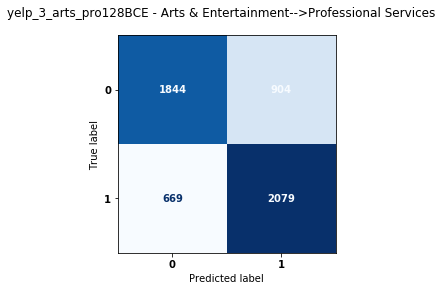

Work on Public Services & Government ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 4566 businesses (overlap with Arts & Entertainment)


  6%|▌         | 15/261 [00:00<00:01, 149.70it/s]

#ss (pos) 522
#ss (neg) 522


100%|██████████| 261/261 [00:01<00:00, 192.46it/s]


#nss 1044
#~ss 2088
review pairs: 2088


  0%|          | 0/66 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 66/66 [00:27<00:00,  3.22it/s]


Time for [prediction]: 0:00:27.054035
Confusion Matrix:
[[685 359]
 [403 641]]

CM: [685 359 403 641] 
[tn, fp, fn, tp]
  accuracy: 0.635
 precision: 0.635
    recall: 0.635
  f1-score: 0.635

Accuracy:  0.635 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Public Services & Government]:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1044
           1       0.64      0.61      0.63      1044

    accuracy                           0.64      2088
   macro avg       0.64      0.64      0.63      2088
weighted avg       0.64      0.64      0.63      2088



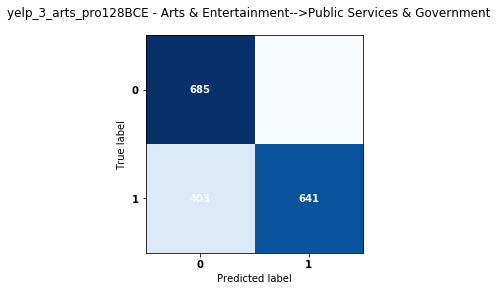

  0%|          | 0/39 [00:00<?, ?it/s]

Work on Religious Organizations ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 477 businesses (overlap with Arts & Entertainment)


100%|██████████| 39/39 [00:00<00:00, 243.71it/s]


#ss (pos) 78
#ss (neg) 78
#nss 156
#~ss 312
review pairs: 312


  0%|          | 0/10 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

Time for [prediction]: 0:00:04.535938
Confusion Matrix:
[[ 89  67]
 [ 46 110]]

CM: [ 89  67  46 110] 
[tn, fp, fn, tp]
  accuracy: 0.638
 precision: 0.640
    recall: 0.638
  f1-score: 0.636

Accuracy:  0.638 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Religious Organizations]:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       156
           1       0.62      0.71      0.66       156

    accuracy                           0.64       312
   macro avg       0.64      0.64      0.64       312
weighted avg       0.64      0.64      0.64       312



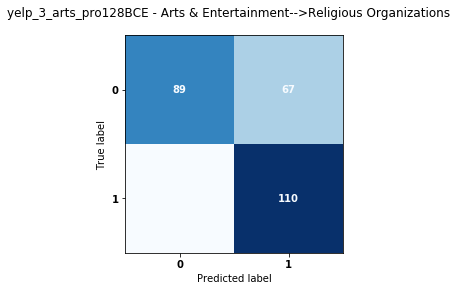

Work on Restaurants ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 170789 businesses (overlap with Arts & Entertainment)


100%|██████████| 32643/32643 [02:35<00:00, 210.23it/s]


#ss (pos) 65286
#ss (neg) 65286


100%|██████████| 32643/32643 [02:34<00:00, 210.63it/s]


#nss 130572
#~ss 261144
review pairs: 261144


  0%|          | 0/8161 [00:00<?, ?it/s]

Start on [prediction] ...


 51%|█████     | 4135/8161 [25:44<26:46,  2.51it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 8161/8161 [52:35<00:00,  2.56it/s]


Time for [prediction]: 0:52:35.182807
Confusion Matrix:
[[82341 48231]
 [44705 85867]]

CM: [82341 48231 44705 85867] 
[tn, fp, fn, tp]
  accuracy: 0.644
 precision: 0.644
    recall: 0.644
  f1-score: 0.644

Accuracy:  0.644 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Restaurants]:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64    130572
           1       0.64      0.66      0.65    130572

    accuracy                           0.64    261144
   macro avg       0.64      0.64      0.64    261144
weighted avg       0.64      0.64      0.64    261144



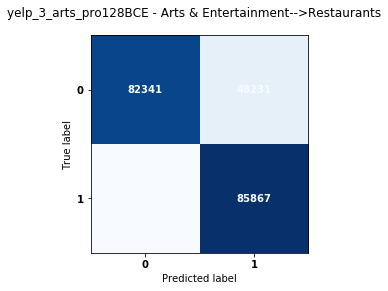

Work on Shopping ...
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 43696 businesses (overlap with Arts & Entertainment)


100%|██████████| 6331/6331 [00:27<00:00, 226.61it/s]


#ss (pos) 12662
#ss (neg) 12662


100%|██████████| 6331/6331 [00:26<00:00, 237.92it/s]


#nss 25324
#~ss 50648
review pairs: 50648


  0%|          | 0/1583 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1583/1583 [10:54<00:00,  3.41it/s]


Time for [prediction]: 0:10:54.460156
Confusion Matrix:
[[16869  8455]
 [ 8267 17057]]

CM: [16869  8455  8267 17057] 
[tn, fp, fn, tp]
  accuracy: 0.670
 precision: 0.670
    recall: 0.670
  f1-score: 0.670

Accuracy:  0.67 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Shopping]:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67     25324
           1       0.67      0.67      0.67     25324

    accuracy                           0.67     50648
   macro avg       0.67      0.67      0.67     50648
weighted avg       0.67      0.67      0.67     50648



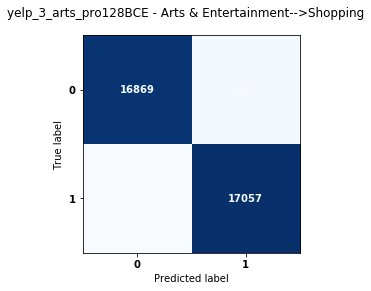

In [51]:
results_cross_no_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # without overlap
    df_other = filter_root_category_businesses_not_other(root_category_label, category_name, inv_cat_bids, map_categories, map_cat_name2id)
    
    df_other = filter_min_review_freq(df_other, min_ratings=5)
    df_other = filter_both_good_bad(df_other)
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=2)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_no_overlap[root_category_label] = res_one

Work on Active Life ...


  0%|          | 0/2039 [00:00<?, ?it/s]

#ss (pos) 4078
#ss (neg) 4078


100%|██████████| 2039/2039 [00:08<00:00, 253.59it/s]


#nss 8156
#~ss 16312
review pairs: 16312


  0%|          | 0/510 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 510/510 [03:45<00:00,  2.12it/s]


Time for [prediction]: 0:03:45.677686
Confusion Matrix:
[[5403 2753]
 [2869 5287]]

CM: [5403 2753 2869 5287] 
[tn, fp, fn, tp]
  accuracy: 0.655
 precision: 0.655
    recall: 0.655
  f1-score: 0.655

Accuracy:  0.655 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Active Life]:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      8156
           1       0.66      0.65      0.65      8156

    accuracy                           0.66     16312
   macro avg       0.66      0.66      0.66     16312
weighted avg       0.66      0.66      0.66     16312



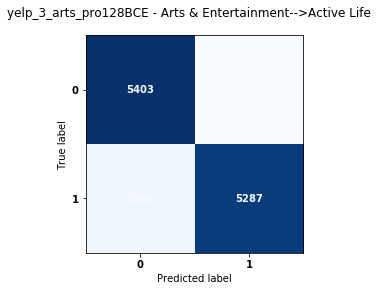

Work on Automotive ...


100%|██████████| 2848/2848 [00:12<00:00, 235.04it/s]


#ss (pos) 5696
#ss (neg) 5696


100%|██████████| 2848/2848 [00:12<00:00, 230.67it/s]


#nss 11392
#~ss 22784
review pairs: 22784


  0%|          | 0/712 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 712/712 [05:15<00:00,  2.46it/s]


Time for [prediction]: 0:05:15.198443
Confusion Matrix:
[[7651 3741]
 [3262 8130]]

CM: [7651 3741 3262 8130] 
[tn, fp, fn, tp]
  accuracy: 0.693
 precision: 0.693
    recall: 0.693
  f1-score: 0.692

Accuracy:  0.693 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Automotive]:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     11392
           1       0.68      0.71      0.70     11392

    accuracy                           0.69     22784
   macro avg       0.69      0.69      0.69     22784
weighted avg       0.69      0.69      0.69     22784



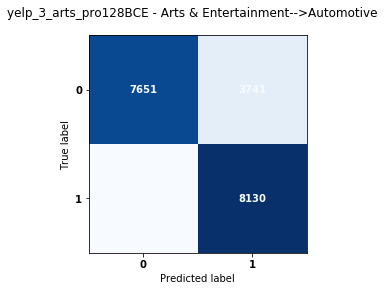

Work on Beauty & Spas ...


100%|██████████| 4991/4991 [00:25<00:00, 195.27it/s]


#ss (pos) 9982
#ss (neg) 9982


100%|██████████| 4991/4991 [00:20<00:00, 245.49it/s]


#nss 19964
#~ss 39928
review pairs: 39928


  0%|          | 0/1248 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1248/1248 [08:34<00:00,  2.49it/s]


Time for [prediction]: 0:08:34.167879
Confusion Matrix:
[[13534  6430]
 [ 5048 14916]]

CM: [13534  6430  5048 14916] 
[tn, fp, fn, tp]
  accuracy: 0.713
 precision: 0.714
    recall: 0.713
  f1-score: 0.712

Accuracy:  0.713 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70     19964
           1       0.70      0.75      0.72     19964

    accuracy                           0.71     39928
   macro avg       0.71      0.71      0.71     39928
weighted avg       0.71      0.71      0.71     39928



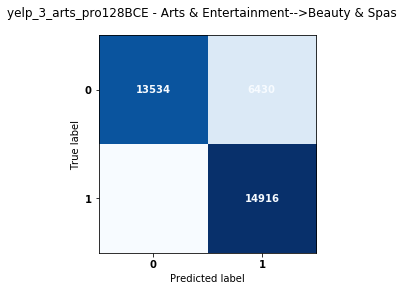

100%|██████████| 1/1 [00:00<00:00, 226.67it/s]

Work on Bicycles ...
#ss (pos) 2
#ss (neg) 2
#nss 4
#~ss 8
review pairs: 8



100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

Start on [prediction] ...
Time for [prediction]: 0:00:00.150383
Confusion Matrix:
[[3 1]
 [3 1]]

CM: [3 1 3 1] 
[tn, fp, fn, tp]
  accuracy: 0.500
 precision: 0.500
    recall: 0.500
  f1-score: 0.467

Accuracy:  0.5 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Bicycles]:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.25      0.33         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8



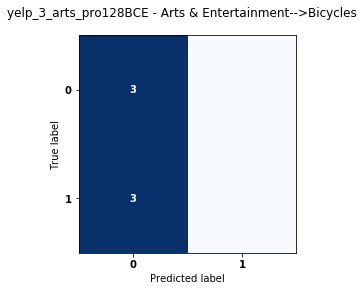

Work on Education ...


  6%|▌         | 26/438 [00:00<00:01, 258.50it/s]

#ss (pos) 876
#ss (neg) 876


100%|██████████| 438/438 [00:01<00:00, 280.94it/s]


#nss 1752
#~ss 3504
review pairs: 3504


  0%|          | 0/110 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 110/110 [00:54<00:00,  2.29it/s]


Time for [prediction]: 0:00:54.315022
Confusion Matrix:
[[1175  577]
 [ 545 1207]]

CM: [1175  577  545 1207] 
[tn, fp, fn, tp]
  accuracy: 0.680
 precision: 0.680
    recall: 0.680
  f1-score: 0.680

Accuracy:  0.68 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Education]:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      1752
           1       0.68      0.69      0.68      1752

    accuracy                           0.68      3504
   macro avg       0.68      0.68      0.68      3504
weighted avg       0.68      0.68      0.68      3504



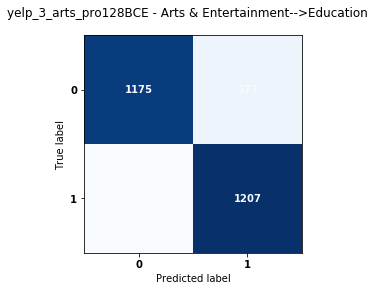

Work on Event Planning & Services ...


100%|██████████| 3706/3706 [00:18<00:00, 200.75it/s]


#ss (pos) 7412
#ss (neg) 7412


100%|██████████| 3706/3706 [00:15<00:00, 241.41it/s]


#nss 14824
#~ss 29648
review pairs: 29648


  0%|          | 0/927 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 927/927 [06:39<00:00,  2.54it/s]


Time for [prediction]: 0:06:39.189372
Confusion Matrix:
[[9776 5048]
 [5252 9572]]

CM: [9776 5048 5252 9572] 
[tn, fp, fn, tp]
  accuracy: 0.653
 precision: 0.653
    recall: 0.653
  f1-score: 0.653

Accuracy:  0.653 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Event Planning & Services]:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     14824
           1       0.65      0.65      0.65     14824

    accuracy                           0.65     29648
   macro avg       0.65      0.65      0.65     29648
weighted avg       0.65      0.65      0.65     29648



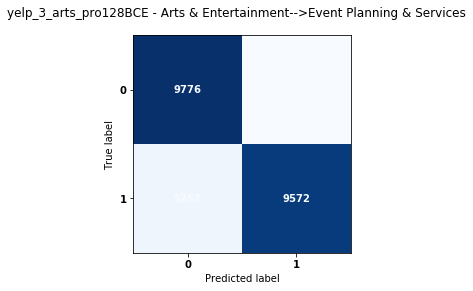

Work on Financial Services ...


  9%|▉         | 27/296 [00:00<00:01, 264.48it/s]

#ss (pos) 592
#ss (neg) 592


100%|██████████| 296/296 [00:01<00:00, 260.94it/s]


#nss 1184
#~ss 2368
review pairs: 2368


  0%|          | 0/74 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 74/74 [00:29<00:00,  2.21it/s]


Time for [prediction]: 0:00:29.463742
Confusion Matrix:
[[814 370]
 [285 899]]

CM: [814 370 285 899] 
[tn, fp, fn, tp]
  accuracy: 0.723
 precision: 0.725
    recall: 0.723
  f1-score: 0.723

Accuracy:  0.723 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Financial Services]:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1184
           1       0.71      0.76      0.73      1184

    accuracy                           0.72      2368
   macro avg       0.72      0.72      0.72      2368
weighted avg       0.72      0.72      0.72      2368



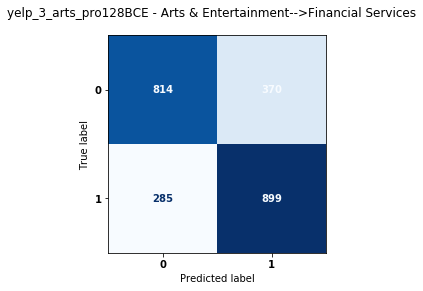

Work on Food ...


100%|██████████| 12779/12779 [00:56<00:00, 224.82it/s]


#ss (pos) 25558
#ss (neg) 25558


100%|██████████| 12779/12779 [01:00<00:00, 212.46it/s]


#nss 51116
#~ss 102232
review pairs: 102232


  0%|          | 0/3195 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 3195/3195 [21:12<00:00,  2.86it/s]


Time for [prediction]: 0:21:13.001893
Confusion Matrix:
[[32249 18867]
 [17758 33358]]

CM: [32249 18867 17758 33358] 
[tn, fp, fn, tp]
  accuracy: 0.642
 precision: 0.642
    recall: 0.642
  f1-score: 0.642

Accuracy:  0.642 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Food]:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64     51116
           1       0.64      0.65      0.65     51116

    accuracy                           0.64    102232
   macro avg       0.64      0.64      0.64    102232
weighted avg       0.64      0.64      0.64    102232



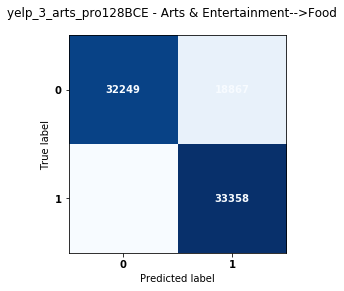

Work on Health & Medical ...


100%|██████████| 3180/3180 [00:17<00:00, 185.36it/s]


#ss (pos) 6360
#ss (neg) 6360


100%|██████████| 3180/3180 [00:15<00:00, 205.11it/s]


#nss 12720
#~ss 25440
review pairs: 25440


  0%|          | 0/795 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 795/795 [06:02<00:00,  2.02it/s]


Time for [prediction]: 0:06:02.316068
Confusion Matrix:
[[8464 4256]
 [3132 9588]]

CM: [8464 4256 3132 9588] 
[tn, fp, fn, tp]
  accuracy: 0.710
 precision: 0.711
    recall: 0.710
  f1-score: 0.709

Accuracy:  0.71 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Health & Medical]:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     12720
           1       0.69      0.75      0.72     12720

    accuracy                           0.71     25440
   macro avg       0.71      0.71      0.71     25440
weighted avg       0.71      0.71      0.71     25440



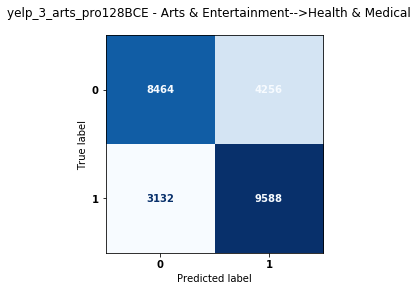

Work on Home Services ...


100%|██████████| 3093/3093 [00:13<00:00, 233.56it/s]


#ss (pos) 6186
#ss (neg) 6186


100%|██████████| 3093/3093 [00:13<00:00, 224.50it/s]


#nss 12372
#~ss 24744
review pairs: 24744


  0%|          | 0/774 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 774/774 [06:03<00:00,  2.42it/s]


Time for [prediction]: 0:06:03.300390
Confusion Matrix:
[[8014 4358]
 [2959 9413]]

CM: [8014 4358 2959 9413] 
[tn, fp, fn, tp]
  accuracy: 0.704
 precision: 0.707
    recall: 0.704
  f1-score: 0.703

Accuracy:  0.704 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Home Services]:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     12372
           1       0.68      0.76      0.72     12372

    accuracy                           0.70     24744
   macro avg       0.71      0.70      0.70     24744
weighted avg       0.71      0.70      0.70     24744



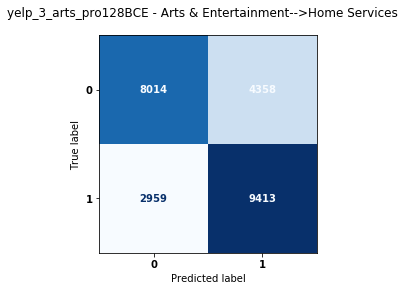

Work on Hotels & Travel ...


100%|██████████| 2223/2223 [00:10<00:00, 213.77it/s]


#ss (pos) 4446
#ss (neg) 4446


100%|██████████| 2223/2223 [00:10<00:00, 217.21it/s]


#nss 8892
#~ss 17784
review pairs: 17784


  0%|          | 0/556 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 556/556 [04:17<00:00,  2.31it/s]


Time for [prediction]: 0:04:18.006497
Confusion Matrix:
[[5750 3142]
 [3087 5805]]

CM: [5750 3142 3087 5805] 
[tn, fp, fn, tp]
  accuracy: 0.650
 precision: 0.650
    recall: 0.650
  f1-score: 0.650

Accuracy:  0.65 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Hotels & Travel]:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      8892
           1       0.65      0.65      0.65      8892

    accuracy                           0.65     17784
   macro avg       0.65      0.65      0.65     17784
weighted avg       0.65      0.65      0.65     17784



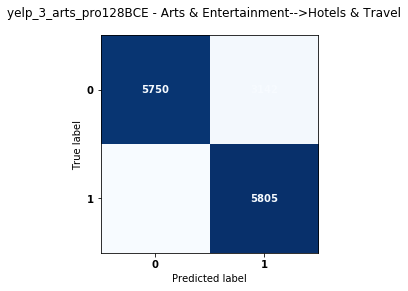

Work on Local Flavor ...


  4%|▍         | 20/508 [00:00<00:02, 199.70it/s]

#ss (pos) 1016
#ss (neg) 1016


100%|██████████| 508/508 [00:02<00:00, 214.64it/s]


#nss 2032
#~ss 4064
review pairs: 4064


  0%|          | 0/127 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 127/127 [00:55<00:00,  2.25it/s]

Time for [prediction]: 0:00:55.342400
Confusion Matrix:
[[1294  738]
 [ 785 1247]]

CM: [1294  738  785 1247] 
[tn, fp, fn, tp]
  accuracy: 0.625
 precision: 0.625
    recall: 0.625
  f1-score: 0.625

Accuracy:  0.625 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Local Flavor]:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      2032
           1       0.63      0.61      0.62      2032

    accuracy                           0.63      4064
   macro avg       0.63      0.63      0.63      4064
weighted avg       0.63      0.63      0.63      4064



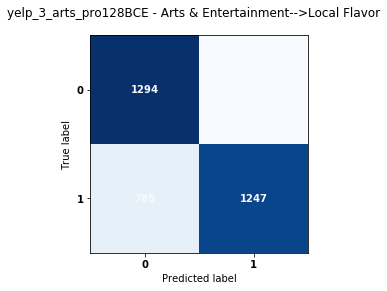

Work on Local Services ...


  0%|          | 0/2331 [00:00<?, ?it/s]

#ss (pos) 4662
#ss (neg) 4662


100%|██████████| 2331/2331 [00:12<00:00, 184.94it/s]


#nss 9324
#~ss 18648
review pairs: 18648


  0%|          | 0/583 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 583/583 [04:17<00:00,  2.53it/s]


Time for [prediction]: 0:04:17.046722
Confusion Matrix:
[[6056 3268]
 [2418 6906]]

CM: [6056 3268 2418 6906] 
[tn, fp, fn, tp]
  accuracy: 0.695
 precision: 0.697
    recall: 0.695
  f1-score: 0.694

Accuracy:  0.695 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Local Services]:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      9324
           1       0.68      0.74      0.71      9324

    accuracy                           0.70     18648
   macro avg       0.70      0.70      0.69     18648
weighted avg       0.70      0.70      0.69     18648



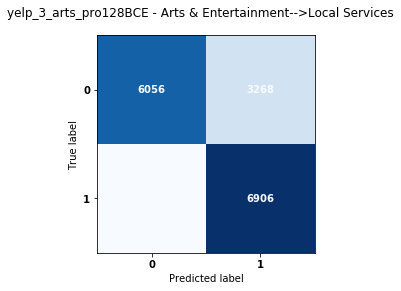

 43%|████▎     | 15/35 [00:00<00:00, 144.02it/s]

Work on Mass Media ...


 40%|████      | 14/35 [00:00<00:00, 137.08it/s]

#ss (pos) 70
#ss (neg) 70


  0%|          | 0/9 [00:00<?, ?it/s]

#nss 140
#~ss 280
review pairs: 280
Start on [prediction] ...


100%|██████████| 9/9 [00:03<00:00,  3.12it/s]

Time for [prediction]: 0:00:03.136895
Confusion Matrix:
[[96 44]
 [50 90]]

CM: [96 44 50 90] 
[tn, fp, fn, tp]
  accuracy: 0.664
 precision: 0.665
    recall: 0.664
  f1-score: 0.664

Accuracy:  0.664 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Mass Media]:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       140
           1       0.67      0.64      0.66       140

    accuracy                           0.66       280
   macro avg       0.66      0.66      0.66       280
weighted avg       0.66      0.66      0.66       280



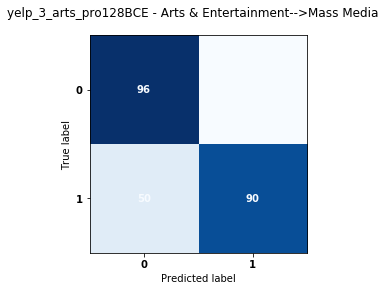

Work on Nightlife ...


100%|██████████| 8157/8157 [00:39<00:00, 205.37it/s]


#ss (pos) 16314
#ss (neg) 16314


100%|██████████| 8157/8157 [00:37<00:00, 219.17it/s]


#nss 32628
#~ss 65256
review pairs: 65256


  0%|          | 0/2040 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 2040/2040 [14:11<00:00,  3.24it/s]


Time for [prediction]: 0:14:11.259721
Confusion Matrix:
[[21473 11155]
 [12482 20146]]

CM: [21473 11155 12482 20146] 
[tn, fp, fn, tp]
  accuracy: 0.638
 precision: 0.638
    recall: 0.638
  f1-score: 0.638

Accuracy:  0.638 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Nightlife]:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64     32628
           1       0.64      0.62      0.63     32628

    accuracy                           0.64     65256
   macro avg       0.64      0.64      0.64     65256
weighted avg       0.64      0.64      0.64     65256



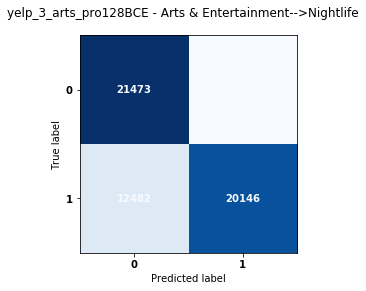

Work on Pets ...


  0%|          | 0/998 [00:00<?, ?it/s]

#ss (pos) 1996
#ss (neg) 1996


100%|██████████| 998/998 [00:05<00:00, 181.55it/s]


#nss 3992
#~ss 7984
review pairs: 7984


  0%|          | 0/250 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 250/250 [02:04<00:00,  2.49it/s]


Time for [prediction]: 0:02:05.004080
Confusion Matrix:
[[2694 1298]
 [1105 2887]]

CM: [2694 1298 1105 2887] 
[tn, fp, fn, tp]
  accuracy: 0.699
 precision: 0.699
    recall: 0.699
  f1-score: 0.699

Accuracy:  0.699 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Pets]:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      3992
           1       0.69      0.72      0.71      3992

    accuracy                           0.70      7984
   macro avg       0.70      0.70      0.70      7984
weighted avg       0.70      0.70      0.70      7984



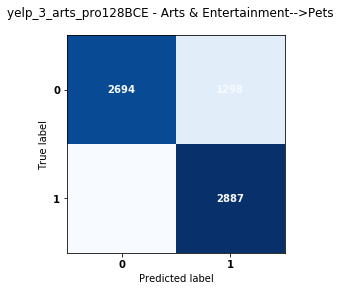

Work on Professional Services ...


  4%|▍         | 30/705 [00:00<00:02, 293.15it/s]

#ss (pos) 1410
#ss (neg) 1410


100%|██████████| 705/705 [00:03<00:00, 219.35it/s]


#nss 2820
#~ss 5640
review pairs: 5640


  0%|          | 0/177 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 177/177 [01:15<00:00,  3.67it/s]


Time for [prediction]: 0:01:15.155873
Confusion Matrix:
[[1815 1005]
 [ 718 2102]]

CM: [1815 1005  718 2102] 
[tn, fp, fn, tp]
  accuracy: 0.695
 precision: 0.697
    recall: 0.695
  f1-score: 0.694

Accuracy:  0.695 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Professional Services]:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      2820
           1       0.68      0.75      0.71      2820

    accuracy                           0.69      5640
   macro avg       0.70      0.69      0.69      5640
weighted avg       0.70      0.69      0.69      5640



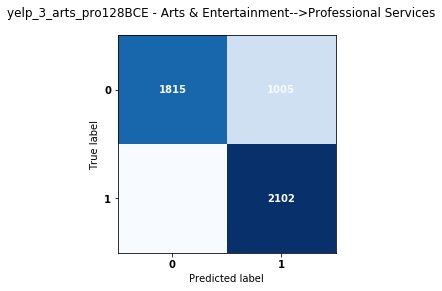

Work on Public Services & Government ...


  9%|▉         | 26/290 [00:00<00:01, 257.34it/s]

#ss (pos) 580
#ss (neg) 580


100%|██████████| 290/290 [00:01<00:00, 265.50it/s]


#nss 1160
#~ss 2320
review pairs: 2320


  0%|          | 0/73 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 73/73 [00:30<00:00,  2.94it/s]

Time for [prediction]: 0:00:30.087155
Confusion Matrix:
[[771 389]
 [435 725]]

CM: [771 389 435 725] 
[tn, fp, fn, tp]
  accuracy: 0.645
 precision: 0.645
    recall: 0.645
  f1-score: 0.645

Accuracy:  0.645 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Public Services & Government]:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1160
           1       0.65      0.62      0.64      1160

    accuracy                           0.64      2320
   macro avg       0.65      0.64      0.64      2320
weighted avg       0.65      0.64      0.64      2320



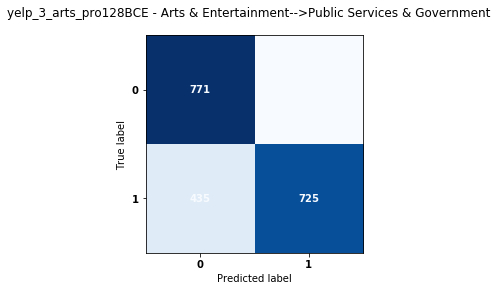

Work on Religious Organizations ...


  0%|          | 0/11 [00:00<?, ?it/s]

#ss (pos) 86
#ss (neg) 86
#nss 172
#~ss 344
review pairs: 344
Start on [prediction] ...


100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

Time for [prediction]: 0:00:04.321931
Confusion Matrix:
[[100  72]
 [ 55 117]]

CM: [100  72  55 117] 
[tn, fp, fn, tp]
  accuracy: 0.631
 precision: 0.632
    recall: 0.631
  f1-score: 0.630

Accuracy:  0.631 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Religious Organizations]:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       172
           1       0.62      0.68      0.65       172

    accuracy                           0.63       344
   macro avg       0.63      0.63      0.63       344
weighted avg       0.63      0.63      0.63       344



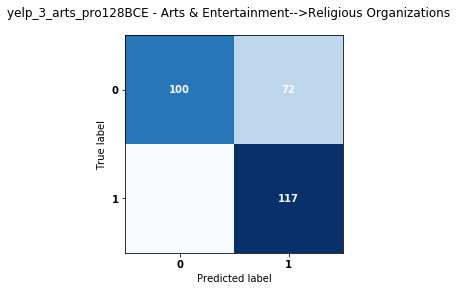

Work on Restaurants ...


100%|██████████| 33354/33354 [02:57<00:00, 188.01it/s]


#ss (pos) 66708
#ss (neg) 66708


100%|██████████| 33354/33354 [02:37<00:00, 212.06it/s]


#nss 133416
#~ss 266832
review pairs: 266832


  0%|          | 0/8339 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 8339/8339 [55:32<00:00,  3.12it/s]  


Time for [prediction]: 0:55:32.008713
Confusion Matrix:
[[84261 49155]
 [45305 88111]]

CM: [84261 49155 45305 88111] 
[tn, fp, fn, tp]
  accuracy: 0.646
 precision: 0.646
    recall: 0.646
  f1-score: 0.646

Accuracy:  0.646 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Restaurants]:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64    133416
           1       0.64      0.66      0.65    133416

    accuracy                           0.65    266832
   macro avg       0.65      0.65      0.65    266832
weighted avg       0.65      0.65      0.65    266832



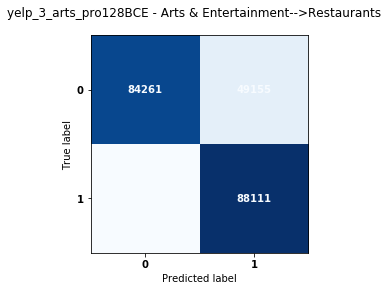

Work on Shopping ...


100%|██████████| 6597/6597 [00:28<00:00, 229.57it/s]


#ss (pos) 13194
#ss (neg) 13194


100%|██████████| 6597/6597 [00:26<00:00, 251.64it/s]


#nss 26388
#~ss 52776
review pairs: 52776


  0%|          | 0/1650 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1650/1650 [11:41<00:00,  2.66it/s]


Time for [prediction]: 0:11:41.493028
Confusion Matrix:
[[17444  8944]
 [ 8780 17608]]

CM: [17444  8944  8780 17608] 
[tn, fp, fn, tp]
  accuracy: 0.664
 precision: 0.664
    recall: 0.664
  f1-score: 0.664

Accuracy:  0.664 

Report for [BERTClassifier - yelp_3_arts_pro128BCE - Arts & Entertainment-->Shopping]:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66     26388
           1       0.66      0.67      0.67     26388

    accuracy                           0.66     52776
   macro avg       0.66      0.66      0.66     52776
weighted avg       0.66      0.66      0.66     52776



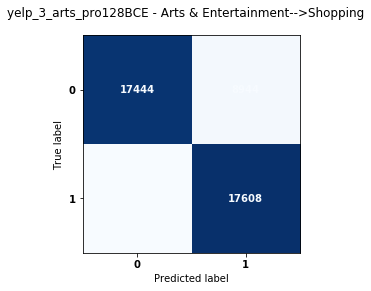

In [52]:
results_cross_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # with overlap
    df_other = load_cached_root_category_businesses_df(root_category_label, map_categories)
    
    df_other = filter_min_review_freq(df_other, min_ratings=5)
    df_other = filter_both_good_bad(df_other)
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=2)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_overlap[root_category_label] = res_one

In [54]:
results_cross_no_overlap

{'Active Life': (13464,
  13464,
  0.6612516772906207,
  0.661096256684492,
  0.6610145748670866,
  0.661096256684492,
  array([[4555, 2177],
         [2386, 4346]])),
 'Automotive': (22632,
  22632,
  0.6937685572996708,
  0.6932219865676917,
  0.6930054986456353,
  0.6932219865676917,
  array([[7544, 3772],
         [3171, 8145]])),
 'Beauty & Spas': (39552,
  39552,
  0.7149389298222291,
  0.7139209142394822,
  0.7135817734681555,
  0.7139209142394822,
  array([[13438,  6338],
         [ 4977, 14799]])),
 'Bicycles': (8,
  8,
  0.3666666666666667,
  0.375,
  0.3650793650793651,
  0.375,
  array([[2, 2],
         [3, 1]])),
 'Education': (2968,
  2968,
  0.6759914068080326,
  0.6758760107816711,
  0.6758228707545092,
  0.6758760107816711,
  array([[ 984,  500],
         [ 462, 1022]])),
 'Event Planning & Services': (25600,
  25600,
  0.6492164825140994,
  0.6491796875,
  0.6491580591350512,
  0.6491796875,
  array([[8209, 4591],
         [4390, 8410]])),
 'Financial Services': (2360

In [55]:
results_cross_overlap

{'Active Life': (16312,
  16312,
  0.6553771880443046,
  0.6553457577243746,
  0.6553283273327595,
  0.6553457577243746,
  array([[5403, 2753],
         [2869, 5287]])),
 'Automotive': (22784,
  22784,
  0.6929763559937059,
  0.6926351825842696,
  0.69249927076277,
  0.6926351825842697,
  array([[7651, 3741],
         [3262, 8130]])),
 'Beauty & Spas': (39928,
  39928,
  0.7135559284035453,
  0.7125325586054898,
  0.7121877562392231,
  0.7125325586054899,
  array([[13534,  6430],
         [ 5048, 14916]])),
 'Bicycles': (8, 8, 0.5, 0.5, 0.4666666666666667, 0.5, array([[3, 1],
         [3, 1]])),
 'Education': (3504,
  3504,
  0.6798545208050892,
  0.6797945205479452,
  0.679767812832329,
  0.6797945205479452,
  array([[1175,  577],
         [ 545, 1207]])),
 'Event Planning & Services': (29648,
  29648,
  0.6526192966926853,
  0.6525903939557475,
  0.6525739452430296,
  0.6525903939557475,
  array([[9776, 5048],
         [5252, 9572]])),
 'Financial Services': (2368,
  2368,
  0.724552

In [60]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_no_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 66.13%  66.11%  66.10%  66.11%  -- [4555, 2177, 2386, 4346]
Automotive                    : 69.38%  69.32%  69.30%  69.32%  -- [7544, 3772, 3171, 8145]
Beauty & Spas                 : 71.49%  71.39%  71.36%  71.39%  -- [13438, 6338, 4977, 14799]
Bicycles                      : 36.67%  37.50%  36.51%  37.50%  -- [2, 2, 3, 1]
Education                     : 67.60%  67.59%  67.58%  67.59%  -- [984, 500, 462, 1022]
Event Planning & Services     : 64.92%  64.92%  64.92%  64.92%  -- [8209, 4591, 4390, 8410]
Financial Services            : 71.96%  71.86%  71.84%  71.86%  -- [810, 370, 294, 886]
Food                          : 64.13%  64.13%  64.12%  64.13%  -- [31446, 18498, 17336, 32608]
Health & Medical              : 71.18%  70.96%  70.89%  70.96%  -- [8348, 4320, 3037, 9631]
Home Services                 : 71.00%  70.74%  70.64%  70.74%  -- [7993, 4287, 2900, 9380]

In [61]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 65.54%  65.53%  65.53%  65.53%  -- [5403, 2753, 2869, 5287]
Automotive                    : 69.30%  69.26%  69.25%  69.26%  -- [7651, 3741, 3262, 8130]
Beauty & Spas                 : 71.36%  71.25%  71.22%  71.25%  -- [13534, 6430, 5048, 14916]
Bicycles                      : 50.00%  50.00%  46.67%  50.00%  -- [3, 1, 3, 1]
Education                     : 67.99%  67.98%  67.98%  67.98%  -- [1175, 577, 545, 1207]
Event Planning & Services     : 65.26%  65.26%  65.26%  65.26%  -- [9776, 5048, 5252, 9572]
Financial Services            : 72.46%  72.34%  72.30%  72.34%  -- [814, 370, 285, 899]
Food                          : 64.18%  64.17%  64.17%  64.17%  -- [32249, 18867, 17758, 33358]
Health & Medical              : 71.12%  70.96%  70.90%  70.96%  -- [8464, 4256, 3132, 9588]
Home Services                 : 70.69%  70.43%  70.33%  70.43%  -- [8014, 4358, 2959, 9413

In [53]:
fn_results = fn_run_path / "results_cross_dicts.p"

with open(fn_results, "wb") as fp:
    pickle.dump((category_name, "overlap", results_cross_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump((category_name, "no overlap", results_cross_no_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)